In [1]:
import pandas as pd
import time
import psutil
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from itertools import combinations
from collections import defaultdict
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import numpy as np
import gc


In [2]:
# Function to measure memory usage
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB

# Function to measure execution time
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    return result, execution_time

In [3]:
# Load the dataset
file_path = 'product.csv'
data = pd.read_csv(file_path, delimiter=';')
transactions = data.groupby(['CustomerID','Date'])['Itemname'].apply(list)
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)
basket_df_int = basket_df.astype(int)

data.info()

C:\Users\Yin\AppData\Local\Temp\ipykernel_15220\837138809.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, delimiter=';')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [4]:
def get_initial_itemsets(transactions):
    item_tidsets = defaultdict(set)
    for tid, transaction in enumerate(transactions):
        for item in transaction:
            item_tidsets[item].add(tid)
    return item_tidsets

def eclat(prefix, items, min_support, tid_dict, freq_itemsets):
    while items:
        i, itids = items.pop()
        new_prefix = prefix + [i]
        support = len(itids)
        if support >= min_support:
            freq_itemsets[frozenset(new_prefix)] = support
            suffix = []
            for j, jtids in items:
                intersection = itids & jtids
                if len(intersection) >= min_support:
                    suffix.append((j, intersection))
            eclat(new_prefix, suffix, min_support, tid_dict, freq_itemsets)


gc.collect()

print("Running Eclat...")
start_time = time.time()
start_memory = memory_usage()

min_support_ratio = 0.01
min_confidence = 0.1
min_support = int(min_support_ratio * len(transactions))

item_tidsets = get_initial_itemsets(transactions)
items = sorted(item_tidsets.items())
freq_itemsets = dict()

eclat([], items, min_support, item_tidsets, freq_itemsets)

itemset_list = [(tuple(itemset), support / len(transactions)) for itemset, support in freq_itemsets.items()]
itemset_list.sort(key=lambda x: x[1], reverse=True)

top_5_itemsets = itemset_list[:5]

top_5_df = pd.DataFrame(top_5_itemsets, columns=['itemsets', 'support'])
top_5_df['support'] = top_5_df['support'].round(6)

k_itemset_counts = defaultdict(int)
for itemset, _ in itemset_list:
    k_itemset_counts[len(itemset)] += 1

total_itemsets = sum(k_itemset_counts.values())

eclat_time = time.time() - start_time
eclat_memory = abs(memory_usage() - start_memory)

# Print results
print(f"Eclat Execution Time: {eclat_time:.4f} seconds")
print(f"Eclat Memory Usage: {eclat_memory:.4f} MB")
print(f"\nTotal number of itemsets found: {total_itemsets}")
print("\nNumber of k-itemsets:")
for k, count in sorted(k_itemset_counts.items()):
    print(f"{k}-itemsets: {count}")
print(f"\nEclat Frequent Itemsets (Top 5):")
print(top_5_df.to_string(index=True))


itemset_df = pd.DataFrame(itemset_list, columns=['itemsets', 'support'])
itemset_df['itemset_size'] = itemset_df['itemsets'].apply(len)

# Top 5 frequent itemsets for itemset_size = 1
top_5_itemsets_size_1 = (
    itemset_df[itemset_df['itemset_size'] == 1]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 2
top_5_itemsets_size_2 = (
    itemset_df[itemset_df['itemset_size'] == 2]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 3
top_5_itemsets_size_3 = (
    itemset_df[itemset_df['itemset_size'] == 3]
    .sort_values(by='support', ascending=False)
    .head(5)
)

print("\nTop 5 Frequent Itemsets (Size 1):")
print(top_5_itemsets_size_1)

print("\nTop 5 Frequent Itemsets (Size 2):")
print(top_5_itemsets_size_2)

print("\nTop 5 Frequent Itemsets (Size 3):")
print(top_5_itemsets_size_3)

gc.collect()


Running Eclat...
Eclat Execution Time: 2.1796 seconds
Eclat Memory Usage: 19.4961 MB

Total number of itemsets found: 992

Number of k-itemsets:
1-itemsets: 629
2-itemsets: 303
3-itemsets: 58
4-itemsets: 2

Eclat Frequent Itemsets (Top 5):
                                itemsets   support
0  (WHITE HANGING HEART T-LIGHT HOLDER,)  0.106186
1            (REGENCY CAKESTAND 3 TIER,)  0.090029
2             (JUMBO BAG RED RETROSPOT,)  0.086930
3       (ASSORTED COLOUR BIRD ORNAMENT,)  0.075144
4                       (PARTY BUNTING,)  0.074812

Top 5 Frequent Itemsets (Size 1):
                                itemsets   support  itemset_size
0  (WHITE HANGING HEART T-LIGHT HOLDER,)  0.106186             1
1            (REGENCY CAKESTAND 3 TIER,)  0.090029             1
2             (JUMBO BAG RED RETROSPOT,)  0.086930             1
3       (ASSORTED COLOUR BIRD ORNAMENT,)  0.075144             1
4                       (PARTY BUNTING,)  0.074812             1

Top 5 Frequent Itemsets (Siz

0


Association Rules Execution Time: 0.0018 seconds
Association Rules Memory Usage: 0.0391 MB

Top 5 Association Rules:

                     antecedents                    consequents   support  confidence       lift
0     (JUMBO BAG PINK POLKADOT,)     (JUMBO BAG RED RETROSPOT,)  0.029825    0.624565   7.184689
1     (JUMBO BAG RED RETROSPOT,)     (JUMBO BAG PINK POLKADOT,)  0.029825    0.343094   7.184689
2    (ALARM CLOCK BAKELIKE RED,)  (ALARM CLOCK BAKELIKE GREEN,)  0.029050    0.614035  14.208505
3  (ALARM CLOCK BAKELIKE GREEN,)    (ALARM CLOCK BAKELIKE RED,)  0.029050    0.672215  14.208505
4     (LUNCH BAG RED RETROSPOT,)     (LUNCH BAG PINK POLKADOT,)  0.028110    0.401264   7.933960


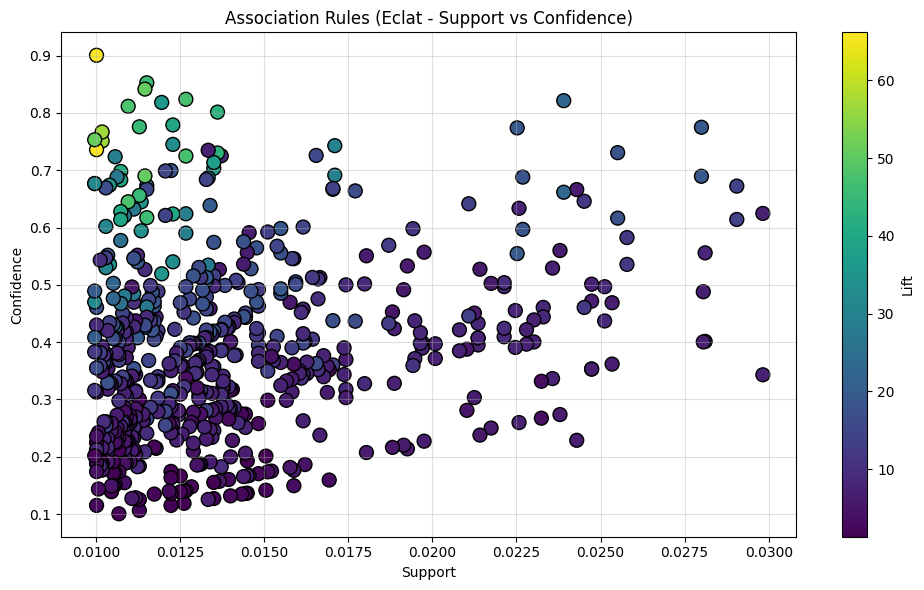

5990

In [5]:
def generate_association_rules(freq_itemsets, transactions, min_confidence):
    rules = []
    num_transactions = len(transactions)
    
    for itemset in freq_itemsets:
        if len(itemset) < 2:
            continue

        support_itemset = freq_itemsets[itemset] / num_transactions
        
        for antecedent in itemset:
            antecedent = frozenset([antecedent])  
            consequent = itemset - antecedent    
            
            if len(consequent) == 1 :
                consequent = frozenset(consequent)
                
                if antecedent in freq_itemsets and consequent in freq_itemsets:
                    support_antecedent = freq_itemsets[antecedent] / num_transactions
                    support_consequent = freq_itemsets[consequent] / num_transactions
                    confidence = support_itemset / support_antecedent
                    lift = confidence / support_consequent if support_consequent > 0 else 0
                    
                    if confidence >= min_confidence:
                        rules.append({
                            'antecedents': tuple(antecedent),
                            'consequents': tuple(consequent),
                            'support': support_itemset,
                            'confidence': confidence,
                            'lift': lift
                        })
    
    return rules

start_time = time.time()
start_memory = memory_usage()

rules = generate_association_rules(freq_itemsets, transactions, min_confidence)

if not rules:
    print("No association rules generated. Try lowering min_confidence or min_support.")
else:
    rules.sort(key=lambda x: x['support'], reverse=True)
    top_5_rules = rules[:5]

    rules_eclat_graph = pd.DataFrame(rules) 
    rules_eclat = pd.DataFrame(top_5_rules) 

    rules_eclat['support'] = rules_eclat['support'].round(6)
    rules_eclat['confidence'] = rules_eclat['confidence'].round(6)
    rules_eclat['lift'] = rules_eclat['lift'].round(6)

    rules_eclat_time = time.time() - start_time
    rules_eclat_memory = abs(memory_usage() - start_memory)

    # Print association rules
    print(f"\nAssociation Rules Execution Time: {rules_eclat_time:.4f} seconds")
    print(f"Association Rules Memory Usage: {rules_eclat_memory:.4f} MB")
    print("\nTop 5 Association Rules:\n")
    print(rules_eclat[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string(index=True))

    # Plot association rules
    plt.figure(figsize=(10, 6))
    plt.scatter(
        rules_eclat_graph['support'], 
        rules_eclat_graph['confidence'], 
        c=rules_eclat_graph['lift'], 
        cmap='viridis', 
        s=100, 
        edgecolor='k'
    )
    plt.colorbar(label='Lift')
    plt.title('Association Rules (Eclat - Support vs Confidence)')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

gc.collect()

In [6]:
gc.collect()

print("Running Apriori...")
start_memory = memory_usage()

frequent_itemsets_apriori, apriori_time = measure_time(
    apriori, basket_df_int, min_support=0.01, use_colnames=True
)

num_itemsets = len(frequent_itemsets_apriori)
frequent_itemsets_apriori['itemset_size'] = frequent_itemsets_apriori['itemsets'].apply(len)
k_itemset_counts = frequent_itemsets_apriori.groupby('itemset_size').size()
top_5_support = frequent_itemsets_apriori.sort_values(by='support', ascending=False).head(5)
apriori_memory = abs(memory_usage() - start_memory)


print(f"Apriori Execution Time: {apriori_time:.4f} seconds")
print(f"Apriori Memory Usage: {apriori_memory:.4f} MB")
print(f"Total Number of Frequent Itemsets: {num_itemsets}")
print("\nNumber of k-itemsets:")
for k, count in k_itemset_counts.items(): 
    print(f"{k}-itemsets: {count}")

print(f"\nApriori Frequent Itemsets (Top 5):\n{top_5_support}")

# Top 5 frequent itemsets for itemset_size = 1
top_5_itemsets_size_1 = (
    frequent_itemsets_apriori[frequent_itemsets_apriori['itemset_size'] == 1]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 2
top_5_itemsets_size_2 = (
    frequent_itemsets_apriori[frequent_itemsets_apriori['itemset_size'] == 2]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 3
top_5_itemsets_size_3 = (
    frequent_itemsets_apriori[frequent_itemsets_apriori['itemset_size'] == 3]
    .sort_values(by='support', ascending=False)
    .head(5)
)

print("\nTop 5 Frequent Itemsets (Size 1):")
print(top_5_itemsets_size_1)

print("\nTop 5 Frequent Itemsets (Size 2):")
print(top_5_itemsets_size_2)

print("\nTop 5 Frequent Itemsets (Size 3):")
print(top_5_itemsets_size_3)

gc.collect()

Running Apriori...


c:\Users\Yin\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Apriori Execution Time: 273.4319 seconds
Apriori Memory Usage: 299.2266 MB
Total Number of Frequent Itemsets: 978

Number of k-itemsets:
1-itemsets: 624
2-itemsets: 298
3-itemsets: 54
4-itemsets: 2

Apriori Frequent Itemsets (Top 5):
      support                              itemsets  itemset_size
591  0.106186  (WHITE HANGING HEART T-LIGHT HOLDER)             1
413  0.090029            (REGENCY CAKESTAND 3 TIER)             1
244  0.086930             (JUMBO BAG RED RETROSPOT)             1
35   0.075144       (ASSORTED COLOUR BIRD ORNAMENT)             1
335  0.074812                       (PARTY BUNTING)             1

Top 5 Frequent Itemsets (Size 1):
      support                              itemsets  itemset_size
591  0.106186  (WHITE HANGING HEART T-LIGHT HOLDER)             1
413  0.090029            (REGENCY CAKESTAND 3 TIER)             1
244  0.086930             (JUMBO BAG RED RETROSPOT)             1
35   0.075144       (ASSORTED COLOUR BIRD ORNAMENT)             1
335  

0

Association Rules Execution Time: 0.0051 seconds
Association Rules Memory Usage: 0.9180 MB
Top 5 Association Rules:
                         antecedents                        consequents  \
0  (PACK OF 72 RETROSPOT CAKE CASES)  (60 CAKE CASES DOLLY GIRL DESIGN)   
1  (60 CAKE CASES DOLLY GIRL DESIGN)  (PACK OF 72 RETROSPOT CAKE CASES)   
2   (72 SWEETHEART FAIRY CAKE CASES)      (60 TEATIME FAIRY CAKE CASES)   
3      (60 TEATIME FAIRY CAKE CASES)   (72 SWEETHEART FAIRY CAKE CASES)   
4   (PACK OF 60 DINOSAUR CAKE CASES)      (60 TEATIME FAIRY CAKE CASES)   

    support  confidence       lift  
0  0.010126    0.184476   9.892720  
1  0.010126    0.543027   9.892720  
2  0.011620    0.437500  12.550000  
3  0.011620    0.333333  12.550000  
4  0.011842    0.419608  12.036751  


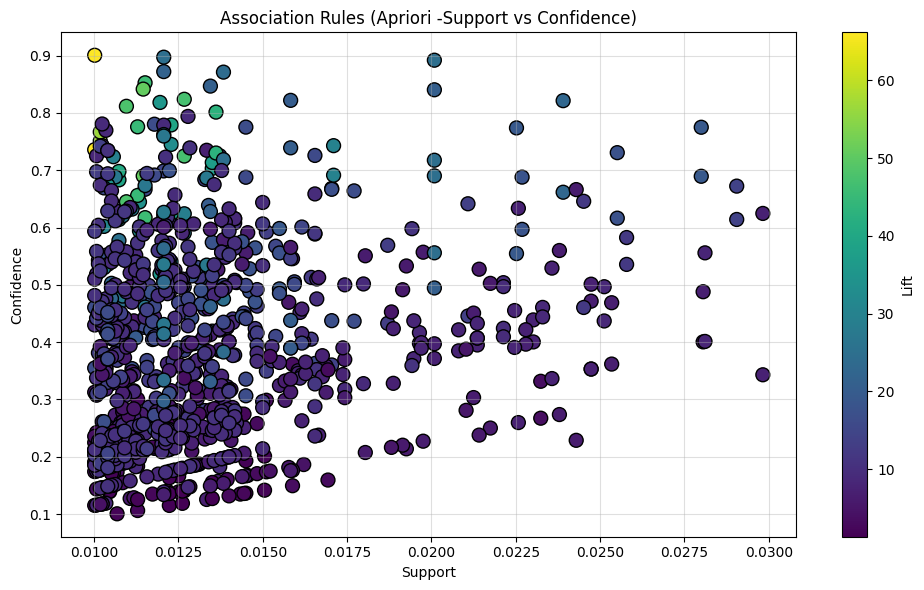

6182

In [7]:
gc.collect()

# Measure memory and time for Association Rules from Apriori
start_memory = memory_usage()
start_time = time.time()
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.1, num_itemsets=3)
rules_apriori_time = time.time() - start_time
rules_apriori_memory = abs(memory_usage() - start_memory)

print(f"Association Rules Execution Time: {rules_apriori_time:.4f} seconds")
print(f"Association Rules Memory Usage: {rules_apriori_memory:.4f} MB")
print("Top 5 Association Rules:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

# Plot association rules
plt.figure(figsize=(10, 6))
plt.scatter(rules_apriori['support'], rules_apriori['confidence'], c=rules_apriori['lift'], cmap='viridis', s=100, edgecolor='k')
plt.colorbar(label='Lift')
plt.title('Association Rules (Apriori -Support vs Confidence)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

gc.collect()

In [8]:
gc.collect()

print("\nRunning FP-Growth...")
start_memory = memory_usage()

frequent_itemsets_fpgrowth, fpgrowth_time = measure_time(
    fpgrowth, basket_df_int, min_support=0.01, use_colnames=True
)

num_itemsets = len(frequent_itemsets_fpgrowth)

frequent_itemsets_fpgrowth['itemset_size'] = frequent_itemsets_fpgrowth['itemsets'].apply(len)
k_itemset_counts = frequent_itemsets_fpgrowth.groupby('itemset_size').size()

top_5_support = frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(5)

fpgrowth_memory = abs(memory_usage() - start_memory)

print(f"FP-Growth Execution Time: {fpgrowth_time:.4f} seconds")
print(f"FP-Growth Memory Usage: {fpgrowth_memory:.4f} MB")
print(f"Total Number of Frequent Itemsets: {num_itemsets}")
print("\nNumber of k-itemsets:")
for k, count in k_itemset_counts.items():
    print(f"{k}-itemsets: {count}")

print(f"\nFP-Growth Frequent Itemsets (Top 5):\n{top_5_support}")

# Top 5 frequent itemsets for itemset_size = 1
top_5_itemsets_size_1 = (
    frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['itemset_size'] == 1]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 2
top_5_itemsets_size_2 = (
    frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['itemset_size'] == 2]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 3
top_5_itemsets_size_3 = (
    frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['itemset_size'] == 3]
    .sort_values(by='support', ascending=False)
    .head(5)
)

print("\nTop 5 Frequent Itemsets (Size 1):")
print(top_5_itemsets_size_1)

print("\nTop 5 Frequent Itemsets (Size 2):")
print(top_5_itemsets_size_2)

print("\nTop 5 Frequent Itemsets (Size 3):")
print(top_5_itemsets_size_3)

gc.collect()


Running FP-Growth...


c:\Users\Yin\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


FP-Growth Execution Time: 10.1401 seconds
FP-Growth Memory Usage: 73.2617 MB
Total Number of Frequent Itemsets: 978

Number of k-itemsets:
1-itemsets: 624
2-itemsets: 298
3-itemsets: 54
4-itemsets: 2

FP-Growth Frequent Itemsets (Top 5):
      support                              itemsets  itemset_size
441  0.106186  (WHITE HANGING HEART T-LIGHT HOLDER)             1
1    0.090029            (REGENCY CAKESTAND 3 TIER)             1
239  0.086930             (JUMBO BAG RED RETROSPOT)             1
497  0.075144       (ASSORTED COLOUR BIRD ORNAMENT)             1
267  0.074812                       (PARTY BUNTING)             1

Top 5 Frequent Itemsets (Size 1):
      support                              itemsets  itemset_size
441  0.106186  (WHITE HANGING HEART T-LIGHT HOLDER)             1
1    0.090029            (REGENCY CAKESTAND 3 TIER)             1
239  0.086930             (JUMBO BAG RED RETROSPOT)             1
497  0.075144       (ASSORTED COLOUR BIRD ORNAMENT)             1
2

385358

Association Rules Execution Time: 0.0038 seconds
Association Rules Memory Usage: 0.0078 MB

Top 5 Association Rules (FP-Growth):
                            antecedents                           consequents  \
0  (WHITE HANGING HEART T-LIGHT HOLDER)            (REGENCY CAKESTAND 3 TIER)   
1            (REGENCY CAKESTAND 3 TIER)  (WHITE HANGING HEART T-LIGHT HOLDER)   
2     (PACK OF 72 RETROSPOT CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)   
3         (60 TEATIME FAIRY CAKE CASES)     (PACK OF 72 RETROSPOT CAKE CASES)   
4  (PACK OF 60 PINK PAISLEY CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)   

    support  confidence       lift  
0  0.012616    0.118812   1.319710  
1  0.012616    0.140135   1.319710  
2  0.017430    0.317540   9.108871  
3  0.017430    0.500000   9.108871  
4  0.014774    0.412037  11.819577  


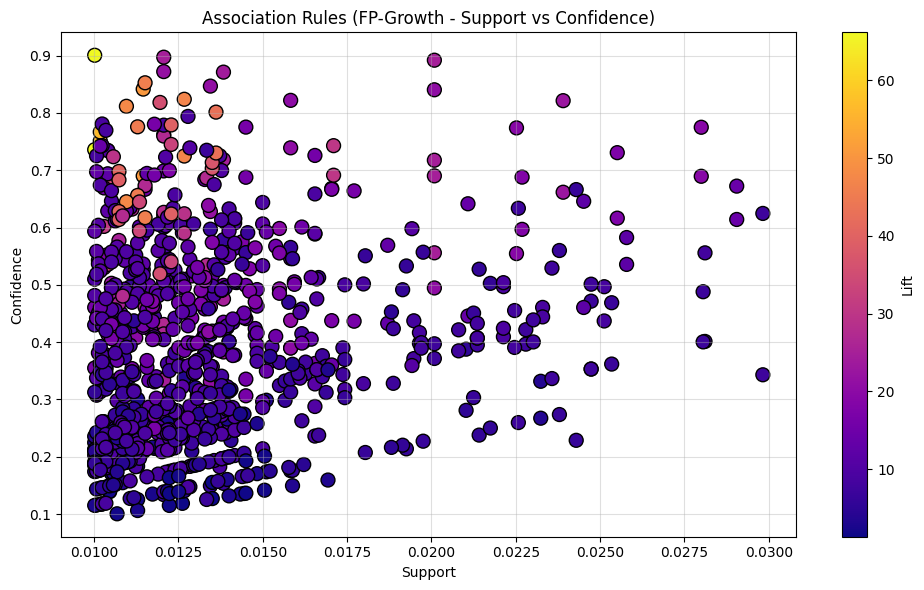

6182

In [9]:
# Measure memory and time for Association Rules from FPGrowth
start_memory = memory_usage()  # Reset baseline memory measurement
start_time = time.time()
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.1, num_itemsets=3)
rules_fpgrowth_time = time.time() - start_time
rules_fpgrowth_memory = memory_usage() - start_memory 

print(f"Association Rules Execution Time: {rules_fpgrowth_time:.4f} seconds")
print(f"Association Rules Memory Usage: {rules_fpgrowth_memory:.4f} MB")
print("\nTop 5 Association Rules (FP-Growth):")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

# Plot association rules from FP-Growth
plt.figure(figsize=(10, 6))
plt.scatter(rules_fpgrowth['support'], rules_fpgrowth['confidence'], c=rules_fpgrowth['lift'], cmap='plasma', s=100, edgecolor='k')
plt.colorbar(label='Lift')
plt.title('Association Rules (FP-Growth - Support vs Confidence)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

gc.collect()

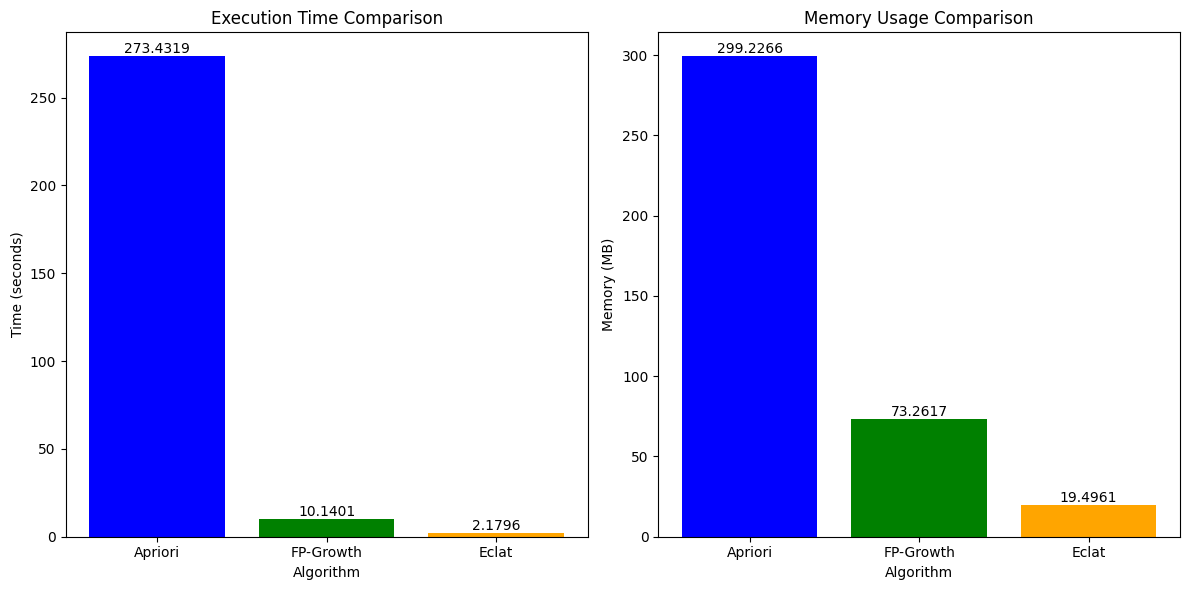

In [10]:
algorithms = ['Apriori', 'FP-Growth', 'Eclat']

execution_times = [apriori_time, fpgrowth_time, eclat_time]
memory_usage = [apriori_memory, fpgrowth_memory, eclat_memory]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(algorithms, execution_times, color=['blue', 'green', 'orange'])
axes[0].set_title('Execution Time Comparison')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_xlabel('Algorithm')
axes[0].bar_label(axes[0].containers[0], fmt='%.4f', label_type='edge')

axes[1].bar(algorithms, memory_usage, color=['blue', 'green', 'orange'])
axes[1].set_title('Memory Usage Comparison')
axes[1].set_ylabel('Memory (MB)')
axes[1].set_xlabel('Algorithm')
axes[1].bar_label(axes[1].containers[0], fmt='%.4f', label_type='edge')

plt.tight_layout()
plt.show()